In [1]:
# image segmentation
import os
import random
import pickle
import shutil
import numpy as np
import tifffile as tif
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from model import simple_unet
from skimage.morphology import binary_dilation

np.set_printoptions(precision = 2)
np.set_printoptions(suppress  = True)

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
def remove_files_in_directory(directory_path):
    try:
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # 
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  
        print(f"Todos los archivos en {directory_path} han sido eliminados.")
    except Exception as e:
        print(f"Se ha encontrado un error: {e}")

def normalize(img):
    img_copy  = img.copy()
    img_copy  = img_copy.astype('float64') 
    img_min   = np.min(img_copy)
    img_max   = np.max(img_copy)
    img_copy  = (img_copy - img_min)/(img_max - img_min)
    return img_copy

def create_circle_filter(N1, N2, R):
    n1   = np.linspace(-N1/2, N1/2, N1, dtype = 'float64')
    n2   = np.linspace(-N2/2, N2/2, N2, dtype = 'float64')
    n1, n2 = np.meshgrid(n1, n2)
    img  = (np.sqrt((n1/R)**2 + (n2/R)**2) <= 1)
    img  = img.astype('float64')
    return img

def convert_8bits(img):
    img_copy  = normalize(img)
    img_copy  = np.round(255*img_copy).astype('uint8')
    return img_copy

def save(filename, *args):
    # Get global dictionary
    glob = globals()
    d = {}
    for v in args:
        # Copy over desired values
        d[v] = glob[v]
    with open(filename, 'wb') as f:
        # Put them in the file 
        pickle.dump(d, f)

In [4]:
img  = tif.imread('data/multi_recorte_1.tif')
mask = mpimg.imread('data/multi_recorte_1.png')[:,:,0]
mask = convert_8bits(mask)

images_path = 'images/'
masks_path  = 'masks/'
edges_path  = 'edges/'

In [5]:
krnl    = create_circle_filter(15, 15, 5)
mask_2  = binary_dilation(mask, krnl)
mask_2  = convert_8bits(mask_2)
edge    = mask_2 - mask

In [6]:
remove_files_in_directory('images')
remove_files_in_directory('masks')
remove_files_in_directory('edges')

Todos los archivos en images han sido eliminados.
Todos los archivos en masks han sido eliminados.
Todos los archivos en edges han sido eliminados.


In [7]:
# Parameters
Nx, Ny, Nz = img.shape
Nw   = 256
step = 100

# Index images
indx_x = np.unique(np.concatenate(([np.arange(0, Nx-Nw, step)], [np.array([Nx-Nw])]), axis = 1))
indx_y = np.unique(np.concatenate(([np.arange(0, Ny-Nw, step)], [np.array([Ny-Nw])]), axis = 1))

# Total images
N      = indx_x.size*indx_y.size

# Cut images and save them
cntr   = 0
X_test = np.zeros((N, Nw, Nw, Nz))
for i in indx_x:
    for j in indx_y:
        cntr  += 1
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        img_block = img[i_idx[:, None], j_idx[None, :], :]
        img_block = convert_8bits(img_block)
        mask_block = mask[i_idx[:, None], j_idx[None, :]]
        edge_block = edge[i_idx[:, None], j_idx[None, :]]
        plt.imsave(images_path + str(cntr) +'.png', img_block) 
        plt.imsave(masks_path + str(cntr) +'.png', mask_block, cmap = 'gray') 
        plt.imsave(edges_path + str(cntr) +'.png', edge_block, cmap = 'gray')

In [8]:
images_paths = sorted(
    [os.path.join(images_path, fname)
     for fname in os.listdir(images_path)
     if fname.endswith(".png")]
)

masks_paths = sorted(
    [os.path.join(masks_path, fname)
     for fname in os.listdir(masks_path)
     if fname.endswith(".png") and not fname.startswith(".")]
)

edges_paths = sorted(
    [os.path.join(edges_path, fname)
     for fname in os.listdir(edges_path)
     if fname.endswith(".png") and not fname.startswith(".")]
)

train_images_paths = images_paths
train_masks_paths  = masks_paths
train_edges_paths  = edges_paths

img_height    = 256
img_width     = 256
img_channels  = 3

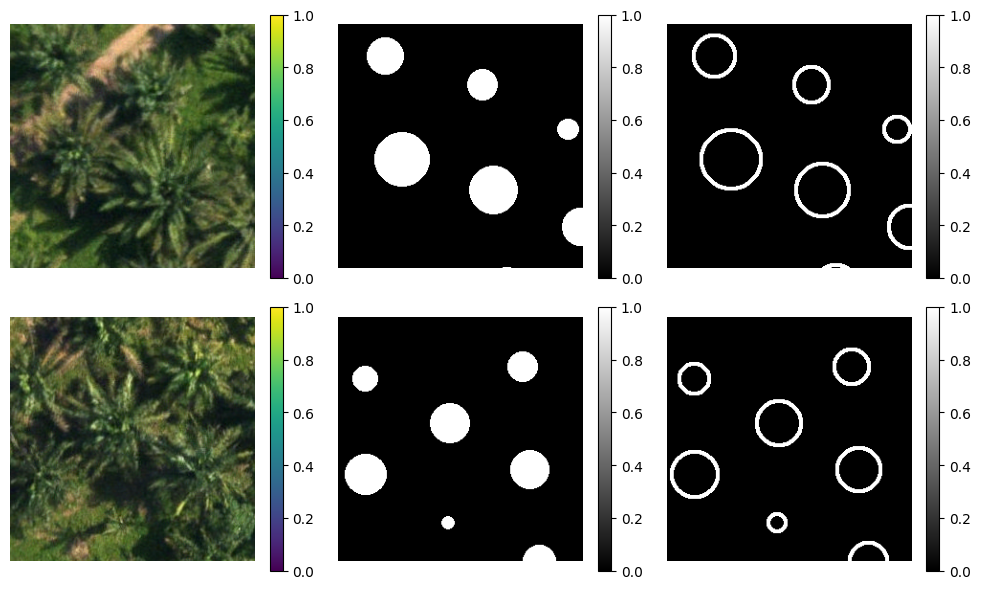

In [9]:
X_train = np.zeros((len(train_images_paths), img_height, img_width, img_channels), dtype= 'float32')
Y_train = np.zeros((len(train_masks_paths), img_height, img_width, 1), dtype = np.bool_)
Y_train_2 = np.zeros((len(train_edges_paths), img_height, img_width, 1), dtype = np.bool_)

for i in range(len(train_images_paths)):   
    img = mpimg.imread(train_images_paths[i])[:,:,:img_channels] 
    img = normalize(img)
    X_train[i] = img  #Fill empty X_train with values from img

    
for i in range(len(train_masks_paths)):   
    img = mpimg.imread(train_masks_paths[i])[:,:,0] 
    img = (img > np.max(np.unique(img))/2).astype(np.bool_)
    img = np.expand_dims(img, axis=2)
    Y_train[i] = img  #Fill empty Y_train with values from img 

for i in range(len(train_edges_paths)):   
    img = mpimg.imread(train_edges_paths[i])[:,:,0] 
    img = (img > np.max(np.unique(img))/2).astype(np.bool_)
    img = np.expand_dims(img, axis=2)
    Y_train_2[i] = img  #Fill empty Y_train with values from img 

# Show trainning images
fig, axs = plt.subplots(2,3, figsize = (10, 6))

h1 = axs[0, 0].imshow(X_train[0])
plt.colorbar(h1, ax = axs[0, 0])
axs[0, 0].axis('off')

h2 = axs[0, 1].imshow(Y_train[0], cmap = 'gray')
plt.colorbar(h2, ax = axs[0, 1])
axs[0, 1].axis('off')

h3 = axs[0, 2].imshow(Y_train_2[0], cmap = 'gray')
plt.colorbar(h3, ax = axs[0, 2])
axs[0, 2].axis('off')

h4 = axs[1, 0].imshow(X_train[1])
plt.colorbar(h4, ax = axs[1, 0])
axs[1, 0].axis('off')

h5 = axs[1, 1].imshow(Y_train[1], cmap = 'gray')
plt.colorbar(h5, ax = axs[1, 1])
axs[1, 1].axis('off')

h6 = axs[1, 2].imshow(Y_train_2[1], cmap = 'gray')
plt.colorbar(h5, ax = axs[1, 2])
axs[1, 2].axis('off')

fig.tight_layout()
plt.show()

In [16]:
model = simple_unet((img_height, img_width, img_channels), n_filt = 8)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
#callbacks
#with tf.device('/cpu:0'):
results = model.fit(X_train, [Y_train, Y_train_2],
                                    validation_split = 0.1,
                                    epochs           = 150)


model.save('model_segmentation.keras')

Epoch 1/150


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/dropout_52/dropout/random_uniform/RandomUniform' defined at (most recent call last):
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\UMB\AppData\Local\Temp\ipykernel_3156\31680066.py", line 3, in <module>
      results = model.fit(X_train, [Y_train, Y_train_2],
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\regularization\dropout.py", line 116, in call
      output = control_flow_util.smart_cond(
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\regularization\dropout.py", line 112, in dropped_inputs
      return self._random_generator.dropout(
    File "C:\Users\UMB\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 2162, in dropout
      return tf.nn.dropout(
Node: 'model_2/dropout_52/dropout/random_uniform/RandomUniform'
OOM when allocating tensor with shape[32,256,256,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/dropout_52/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13077]

In [ ]:
plt.figure(figsize=(12,6))
plt.semilogy(results.history['loss'], label = 'Loss')
plt.semilogy(results.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.legend()
plt.grid('on')
plt.show()